In [1]:
import pandas as pd

seeds = [i+1 for i in range(10)]
# base = '../../datalake/v0_1_3/standard/data/xbipedal/initialconditions'
base = '../../datalake/data_baseline/data/xdpole/initialconditions'

ic = pd.read_csv(f"{base}/s1_run.csv")

In [2]:
# n_features = 200
n_features = 6

features = ic.columns[[i for i in range(n_features)]]
target = 'performance'
X, y = ic[features], ic[target]

In [4]:
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

if n_features > 10:
    k = np.ceil(np.sqrt(n_features))
else:
    k = n_features


s = SelectKBest(score_func=f_regression, k=int(k))
t = PolynomialFeatures(2)

print("k:", k)
print("features:", k ** 2)

k: 6
features: 36


In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# m = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100), activation='logistic')
# m.partial_fit(X, y)

# m = Lasso(alpha=10, tol=10e-10)
m = Ridge(alpha=.0001)

def model(X, y, m) -> MLPRegressor:
    m.fit(X, y)
    return m

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, style='white')
plt.figure(dpi=600)

_y = []
_yp = []
_m = []
_r = []

def critic(c, m, t, X, y, _y, _yp, s):
    if c:
        yp = m.predict(X)
        _yp += list(yp.flatten())
        _y += list(y.flatten())
        _r.append(m.score(X,y))
        c = 0
    else:
        m = model(X, y, m)
        c = 1
    return c, m, t

gmax = len(X)
print(gmax)
g = 10000
batch = 100
c = 0

while g < gmax:
    gnext = g+batch
    yg = np.array(y[g:gnext]).reshape(-1,1)

    Xg = X[g:gnext]
    Xg = s.fit_transform(Xg, yg)
    Xg = t.fit_transform(Xg, yg)

    c, m, t = critic(c, m, t, Xg, yg, _y, _yp, s)
    if c: _m.append(m)

    g = gnext

residual = [abs(_y[i]-_yp[i]) for i in range(len(_y))]
print(residual)

34540
[471.45933803117805, 206.67277176197615, 457.84664484119094, 454.5503695945538, 299.93434351019266, 494.4369769332112, 466.22228860535165, 419.5569688900754, 414.2551115180575, 160.88783277714458, 458.08791035451804, 378.4692263207772, 526.9878357609812, 320.0590747429253, 541.1282987034027, 418.92139904639293, 393.9373865395405, 641.6034624692727, 288.26618752017873, 363.2568107520434, 690.0428641717665, 259.2745993909391, 84.63628131424298, 97.61141494447111, 486.26740750889167, 500.0609374191414, 323.72014786892123, 461.9349769985856, 455.86820361883565, 303.84549752192424, 122.22463339296394, 55.09825297824011, 82.4791102925144, 238.49611262698102, 367.85387876332607, 28.654566376402954, 214.82850363033515, 282.426166286097, 315.72142307338754, 858.593346734452, 134.95980905219312, 156.79725878504883, 668.7956633906115, 511.52294140445133, 383.888651433434, 157.52410003199816, 248.9174503449176, 240.40702755854477, 280.7885419108719, 480.41578569016167, 649.9854990492847, 415

<Figure size 9600x6000 with 0 Axes>

<Axes: >

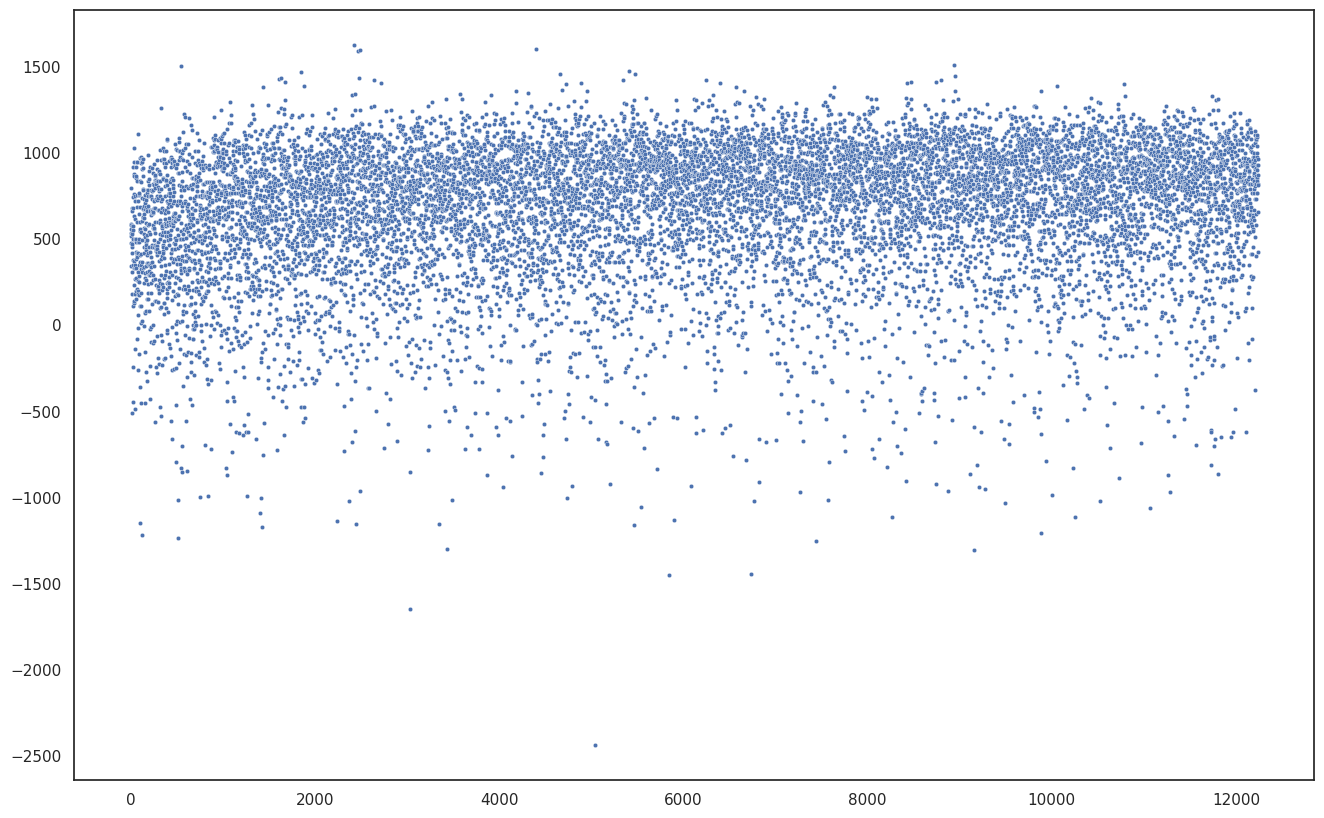

In [ ]:
sns.scatterplot(_yp, s=10, markers="x")

Text(0.5, 0, 'Absolute Residual')

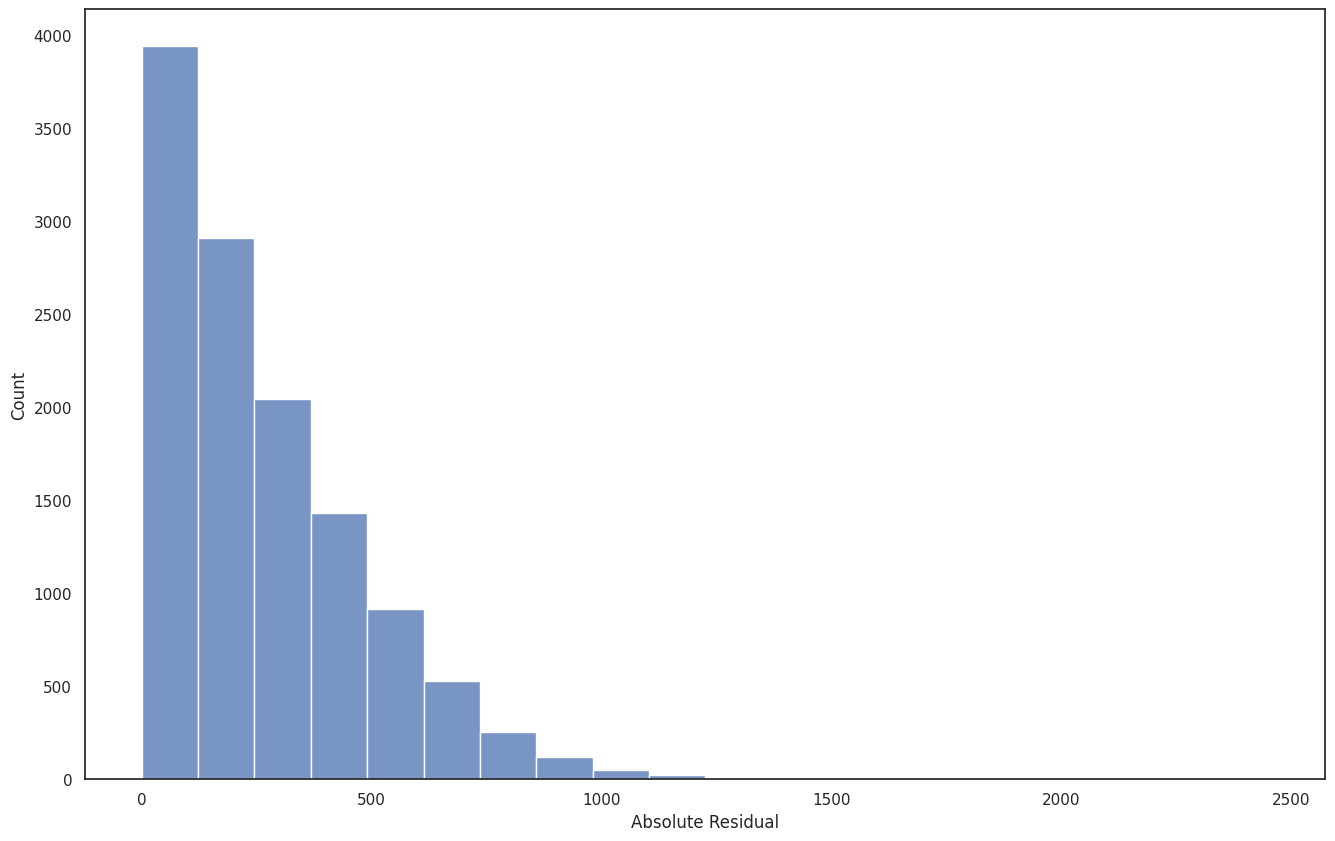

In [ ]:
sns.histplot(residual, bins=20)
plt.xlabel("Absolute Residual")

<Axes: >

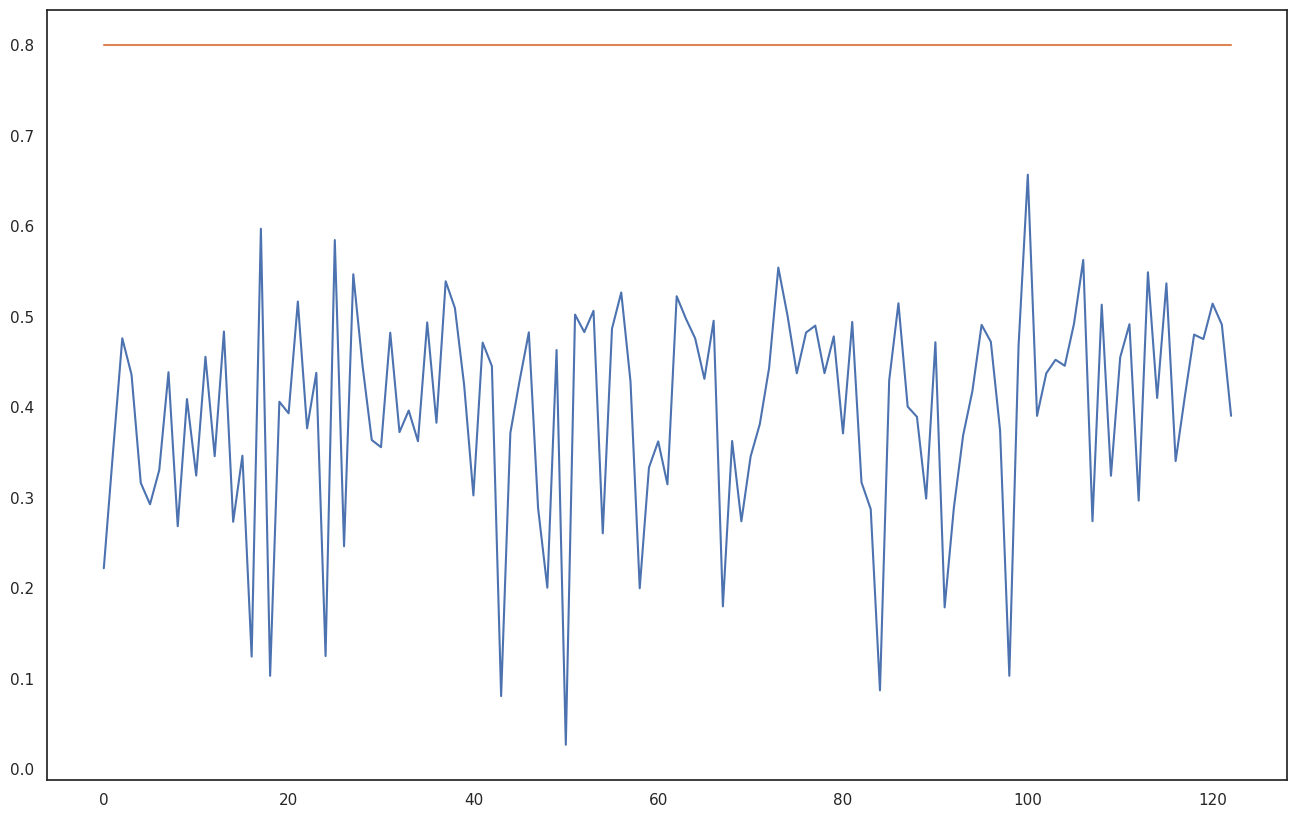

In [ ]:
limit = 1

def truncate_limits(x):
    if x < -limit:
        return -limit
    if x > limit:
        return limit
    return x

sns.lineplot([truncate_limits(x) for x in _r])
sns.lineplot([0.8 for _ in _r])

Text(0.5, 0, 'R-squared')

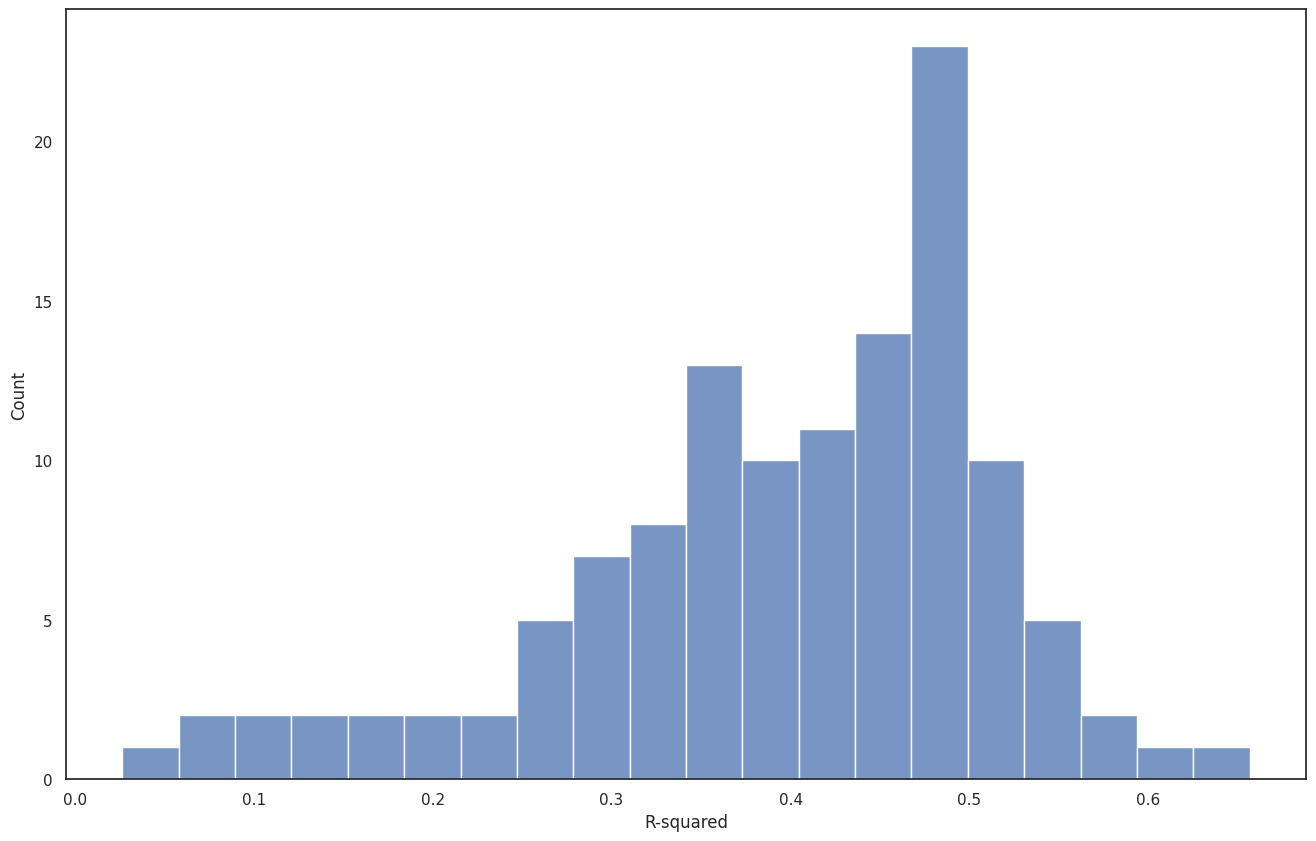

In [ ]:
sns.histplot([truncate_limits(i) for i in _r], bins=20)
plt.xlabel("R-squared")

In [ ]:
d = pd.Series([abs(_yp[-i]/_y[-i]) for i in range(len(_y))])

d.describe()

count    12240.000000
mean         4.256022
std          7.161173
min          0.002854
25%          0.799481
50%          1.001663
75%          5.518790
max        128.077749
dtype: float64